In [7]:
import cv2
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline  

from projection_dataset import ProjectionDataset
%load_ext autoreload
%autoreload 2

In [8]:
dataset_dir = "../data/projections"
subjects = ["P1", "P2", "P3", "P4", "P5", "P6", "P7", "P8"]
gestures = ["1", "2", "3", "4", "5", "6", "7", "8", "9", "I", "IP", "L", "MP", "RP", "T", "TIP", "Y"]

plane = "XY" # Other planes: YZ and ZX

In [9]:
dataset = ProjectionDataset(dataset_dir, subjects, gestures, plane)

torch.Size([1, 96, 96])


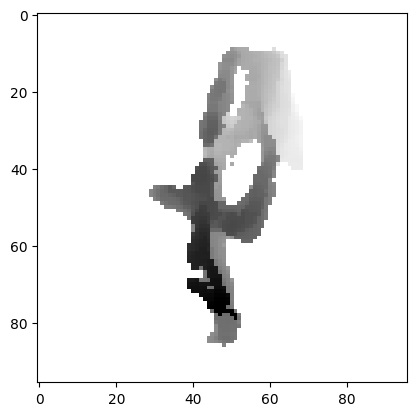

In [12]:
train_dataloader = DataLoader(dataset, batch_size = 1, shuffle=True)
test, bbox, joint_uvs = next(iter(train_dataloader))
print(test.shape)
plt.imshow(torch.squeeze(test, 0).numpy(), cmap='gray', vmin=0, vmax=1)
plt.show()